In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data from the GitHub raw URL
url = "https://raw.githubusercontent.com/btenneson/public_projects/main/tumor2-predator3.csv"
data = pd.read_csv(url)

# Load the CSV file from your local directory
# Replace 'your_file.csv' with the actual path to your CSV file
# data = pd.read_csv("G:\\My Drive\\research\\kaggle\\tumor2-predator3.csv")


# Define the objective function to maximize the absolute correlation
def objective_function(bias, data):
    # Calculate synthetic scores
    synthetic_scores = data.iloc[:, 1:].dot(bias)
    
    # Correlation with the first column
    correlation = np.corrcoef(data.iloc[:, 0], synthetic_scores)[0, 1]
    
    # Minimize the negative absolute correlation
    return -abs(correlation)

# Initial guess for the bias vector (random values, no need to normalize)
n_minus_1 = data.shape[1] - 1  # Assuming data includes the first column
initial_bias = np.random.rand(n_minus_1)

# Minimization process
result = minimize(
    objective_function,
    initial_bias,
    args=(data,),
    method='Powell',
    options={'disp': True}
)

# Check results
if result.success:
    optimized_bias = result.x
    print("Optimized bias vector:", optimized_bias)
    print("Achieved correlation:", -result.fun)  # Negate to show maximized correlation
else:
    print("Optimization failed:", result.message)

Optimization terminated successfully.
         Current function value: -0.918287
         Iterations: 3
         Function evaluations: 277
Optimized bias vector: [1.39626801 0.88485555 0.7141712  0.36455708 0.4530679  1.9592038
 0.84352183 0.80214938 0.04233776]
Achieved correlation: 0.9182865098621251


In [3]:
len(optimized_bias)

9

Best Threshold: 0.34
Best Accuracy: 97.65%
Confusion Matrix:
 [[430  13]
 [  3 236]]
F1 Score: 0.9672131147540983
Precision: 0.9477911646586346
Recall: 0.9874476987447699
AUC: 0.9957308952841504


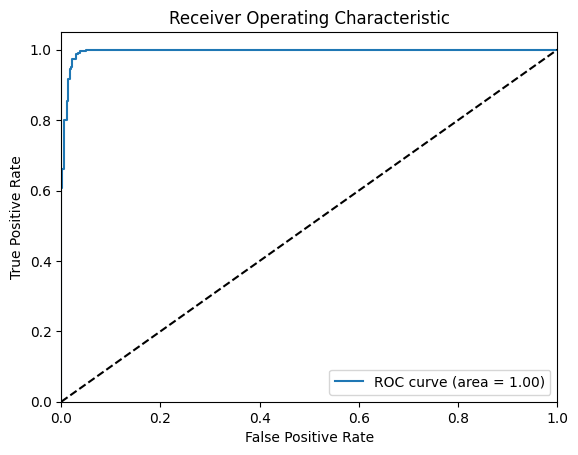

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and 'synthetic_scores' column is calculated
if 'synthetic_scores' not in data.columns:
    # Placeholder for your synthetic_scores calculation logic
    synthetic_scores = data.iloc[:, 1:].dot(optimized_bias)
    data['synthetic_scores'] = synthetic_scores

# Initialize the linear regression model
model = LinearRegression()

# The input X needs to be reshaped for fitting with sklearn (single feature)
X = data['synthetic_scores'].values.reshape(-1, 1)  # Predictor - synthetic scores
y = data.iloc[:, 0].values  # Response variable from the first column

# Fit the model
model.fit(X, y)

# Use the model to make predictions
fitted_scores = model.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [5]:
import lightgbm as lgb

# Assuming 'synthetic_scores' is already calculated and part of your DataFrame
X = data['synthetic_scores'].values.reshape(-1, 1)  # Use synthetic scores as features
y = data.iloc[:, 0].values  # The target variable

# Convert the data into LightGBM dataset format
lgb_train = lgb.Dataset(X, label=y)

# Define LightGBM parameters
params = {
    'objective': 'binary',  # Assuming the target is binary
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
gbm = lgb.train(params, lgb_train, num_boost_round=100)

[LightGBM] [Info] Number of positive: 239, number of negative: 443
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 682, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350440 -> initscore=-0.617106
[LightGBM] [Info] Start training from score -0.617106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Best Threshold: 0.71
Best Accuracy: 98.24%
Confusion Matrix:
 [[438   5]
 [  7 232]]
F1 Score: 0.9747899159663865
Precision: 0.9789029535864979
Recall: 0.9707112970711297
AUC: 0.9988382746016604


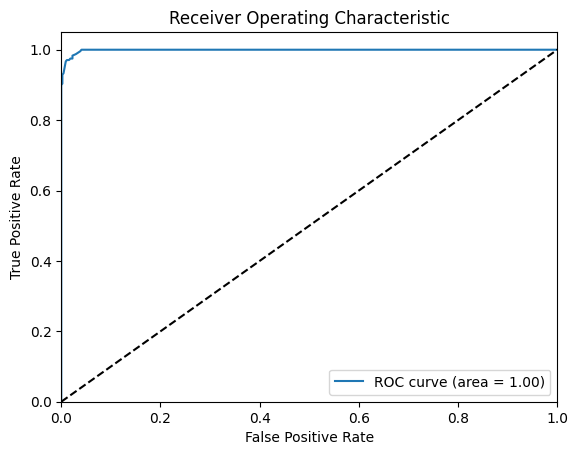

In [6]:
# Make predictions
fitted_scores = gbm.predict(X)

# Function to calculate accuracy for a given threshold
def calculate_accuracy(threshold):
    y_pred = (fitted_scores >= threshold).astype(int)
    return accuracy_score(y, y_pred)

# Test thresholds from 0.0 to 1.0 in small increments
thresholds = np.arange(0.0, 1.01, 0.01)
accuracies = [calculate_accuracy(t) for t in thresholds]

# Find the threshold with the highest accuracy
best_threshold_index = np.argmax(accuracies)
best_threshold = thresholds[best_threshold_index]
best_accuracy = accuracies[best_threshold_index]

# Generate predictions using the best threshold
best_predicted_labels = (fitted_scores >= best_threshold).astype(int)
data['Optimized_Predicted'] = best_predicted_labels

# Print results
print(f"Best Threshold: {best_threshold}")
print(f"Best Accuracy: {best_accuracy * 100:.2f}%")

# Additional metrics
conf_matrix = confusion_matrix(y, best_predicted_labels)
f1 = f1_score(y, best_predicted_labels)
precision = precision_score(y, best_predicted_labels)
recall = recall_score(y, best_predicted_labels)
auc = roc_auc_score(y, fitted_scores)

print("Confusion Matrix:\n", conf_matrix)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y, fitted_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()